In [34]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
from scipy.ndimage import shift
from scipy.constants import h, c

import os
import sys
sys.path.append('..\Functions')

from laser_dfb import *
from laser_cw import *
from AuxiliaryFunctions import *

from commpy.utilities  import upsample
from optic.dsp.core import firFilter, pulseShape, signal_power
from optic.utils import parameters
from optic.models.amplification import get_spectrum
from optic.models.devices import basicLaserModel

In [35]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

figsize(9,6)
plt.style.use('bmh')

# DFB Parameters

In [36]:
laser_dfb_parameters = parameters()
laser_dfb_parameters.noise_terms = True
laser_dfb_parameters.v       = 1.0       # [cm3]  active layer volume
laser_dfb_parameters.tau_n   = 0.33e-9   # [s]    electron lifetime
laser_dfb_parameters.a0      = 2.50e-6   # [cm2]  active layer gain coefficient
laser_dfb_parameters.vg      = 4.52e+9   # [cm/s] group velocity
laser_dfb_parameters.n_t     = 8.2e6     # [cm-1] carrier density at transparency
laser_dfb_parameters.epsilon = 4.58e-8   # [cm3] gain compression factor
laser_dfb_parameters.tau_p   = 7.15e-12  # [s] photon lifetime
laser_dfb_parameters.gamma   = 1.0       # mode confinement factor
laser_dfb_parameters.beta    = 3.54e-5   # fraction of spontaneous emission coupling
laser_dfb_parameters.alpha   = 1.55      # linewidth enchancement factor
laser_dfb_parameters.sigma   = 2e-20     # gain cross section
laser_dfb_parameters.i_bias  = 0.0129    # [A] i_bias
laser_dfb_parameters.i_max   = 0.0300    # [A] i_max
laser_dfb_parameters.eta_0   = 0.21      # total differential quantum efficiency
laser_dfb_parameters.lmbd    = 1540e-9   # [m] wavelength

# Current insertion

## Simple example

in this section, we will define a current signal to be injected in the DFB laser. First we create a bit sequence and pass it through a NRZ pulse shape.

In [23]:
# simulation parameters
SpS = 256
Rs = 2.5e9   # Symbol rate (for OOK case Rs = Rb)
Tsymb = 1/Rs # Symbol period in seconds
Fs = 1/(Tsymb/SpS) # Signal sampling frequency (samples/second)
Ts = 1/Fs # Sampling period

# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size=32)
n = np.arange(0, bitsTx.size)

# upsampling
symbolsUp = upsample(bitsTx, SpS)

# typical NRZ pulse
pulse = pulseShape('rect', SpS)
pulse = pulse/max(abs(pulse))

# pulse formatting
sigTx = firFilter(pulse, symbolsUp)

sigTx = shift(sigTx, int(SpS/2), cval=sigTx[0])  # Shifts the signal to the right and fill the new created empty values with a constant = cval 
t = np.arange(0,SpS*len(bitsTx))*Ts

After that, we will pass that RF binary signal through an FIR filter, and then solve for the DFB laser model, then generating the optical power plots

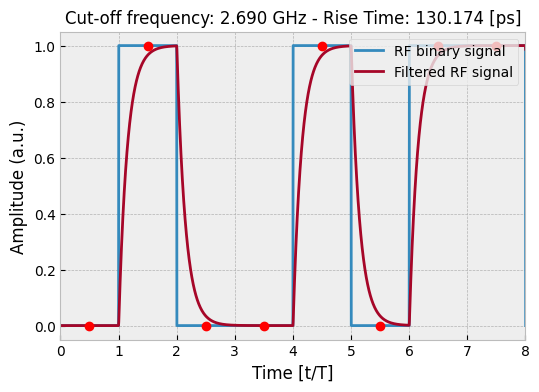

In [27]:
# Filter parameters
R = 59.17
C = 1.e-12
# Filter cut-off
f_cut = 1./(2.*np.pi*R*C)
# Signal filtering
b,a = rc_filter(R, C, Fs, 'low')
zi = signal.lfilter_zi(b, a)  # Create initial conditions for the FIR filter
z, _ = signal.lfilter(b, a, sigTx, zi=zi*sigTx[0]) # Apply the digital FIR filter on the signal (sigTx)

# Plot bits, rf signal and filtered signal
plt.figure(figsize=(6,4))
plt.plot(t*Rs, sigTx, label = 'RF binary signal', linewidth=2)
plt.plot(t*Rs, z, label = 'Filtered RF signal', linewidth=2)
plt.plot(t[int(SpS/2)::SpS]*Rs, bitsTx, 'ro')
plt.title('Cut-off frequency: %.3f GHz - Rise Time: %.3f [ps]'%(1e-9*f_cut,2.2*R*C*1e12), fontsize=12)
plt.ylabel('Amplitude (a.u.)')
plt.xlabel('Time [t/T]')
plt.xlim([0,8])
plt.legend(loc='upper right')
plt.grid(True)

With the current generated, apply it on a laser.solve() method to generate the power curves. Only time (t) and amplitude (z) arrays of the current are necessary

I_threshold: 9.990 mA
I_on: 42.900 mA
I_off: 12.900 mA


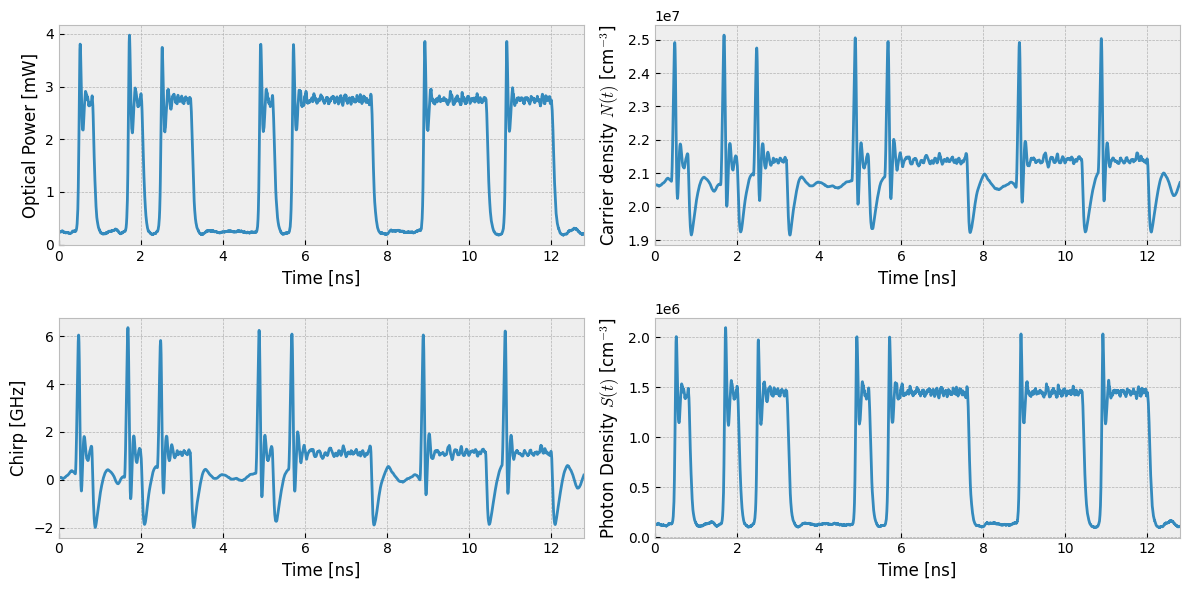

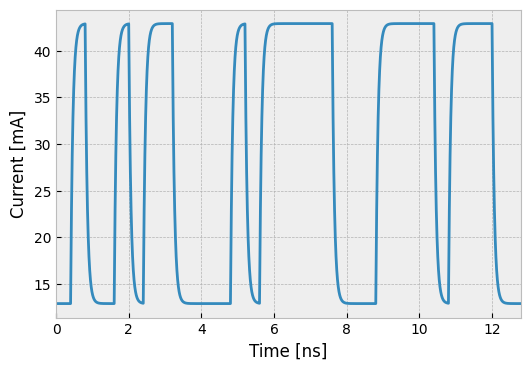

In [28]:
laser_dfb_parameters.noise_terms = True
laser = laser_dfb(laser_dfb_parameters)
sol = laser.solve(t, z)

laser.plot()
print('I_threshold: %.3f mA'%(1e3*laser.ith))
print('I_on: %.3f mA'%(1e3*np.real(laser.current.max())))
print('I_off: %.3f mA'%(1e3*np.real(laser.current.min())))

plt.figure(figsize=(6,4))
plt.plot(1e9*laser.t, 1e3*laser.current)
plt.xlabel('Time [ns]')
plt.ylabel('Current [mA]')
plt.xlim([1e9*t.min(), 1e9*t.max()])
plt.grid(True)

## Spectral representation: Modulated

In [88]:
# simulation parameters
SpS = 256
Rs = 2.5e9   # Symbol rate (for OOK case Rs = Rb)
Tsymb = 1/Rs # Symbol period in seconds
Fs = 1/(Tsymb/SpS) # Signal sampling frequency (samples/second)
Ts = 1/Fs # Sampling period

# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size=2**12)
n = np.arange(0, bitsTx.size)

# upsampling
symbolsUp = upsample(bitsTx, SpS)

# typical NRZ pulse
pulse = pulseShape('rect', SpS)
pulse = pulse/max(abs(pulse))

# pulse formatting
sigTx = firFilter(pulse, symbolsUp)

sigTx = shift(sigTx, int(SpS/2), cval=sigTx[0])  # Shifts the signal to the right and fill the new created empty values with a constant = cval 
t = np.arange(0,SpS*len(bitsTx))*Ts

# Filter parameters
R = 59.17
C = 1.e-12

# Signal filtering
b,a = rc_filter(R, C, Fs, 'low')
zi = signal.lfilter_zi(b, a)  # Create initial conditions for the FIR filter
z, _ = signal.lfilter(b, a, sigTx, zi=zi*sigTx[0]) # Apply the digital FIR filter on the signal (sigTx)

In [89]:
laser_dfb_parameters.noise_terms = True
laser1 = laser_dfb(laser_dfb_parameters)
sol = laser1.solve(t, z)

c:\Users\PC\Documents\GitHub\Laser-Study\Tests\..\Functions\laser_dfb.py:119: RuntimeWarning: invalid value encountered in sqrt
  fs = np.random.randn()*np.sqrt(2*dss/self.t_step)
c:\Users\PC\Documents\GitHub\Laser-Study\Tests\..\Functions\laser_dfb.py:121: RuntimeWarning: invalid value encountered in sqrt
  fp = np.random.randn()*np.sqrt(2*dpp/self.t_step)


Text(0.5, 1.0, 'DFB laser spectrum')

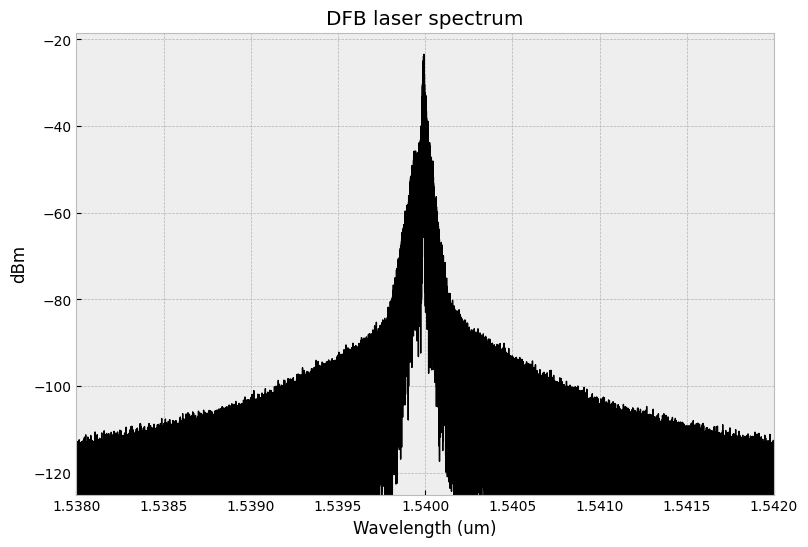

In [90]:
freq, spectrum = get_spectrum(laser1.e_out, Fs=Fs, Fc=c/laser1.lmbd)
plt.plot(freq*1e6, spectrum, color='black',linewidth = 1)
plt.xlim(1.538,1.542)
plt.ylim(-125,np.max(spectrum)+5)
plt.ylabel('dBm')
plt.xlabel('Wavelength (um)')
plt.title('DFB laser spectrum')

## Spectral representation: CW

In [91]:
# simulation parameters
SpS = 256
Rs = 2.5e9   # Symbol rate (for OOK case Rs = Rb)
Tsymb = 1/Rs # Symbol period in seconds
Fs = 1/(Tsymb/SpS) # Signal sampling frequency (samples/second)
Ts = 1/Fs # Sampling period

# generate pseudo-random bit sequence
bitsTx = np.ones(2**12)
n = np.arange(0, bitsTx.size)

# upsampling
symbolsUp = upsample(bitsTx, SpS)

# typical NRZ pulse
pulse = pulseShape('rect', SpS)
pulse = pulse/max(abs(pulse))

# pulse formatting
sigTx = firFilter(pulse, symbolsUp)

sigTx = shift(sigTx, int(SpS/2), cval=sigTx[0])  # Shifts the signal to the right and fill the new created empty values with a constant = cval 
t = np.arange(0,SpS*len(bitsTx))*Ts

I_threshold: 9.990 mA
I_on: 42.900 mA
I_off: 42.900 mA


c:\Users\PC\Documents\PythonVenvs\TCCvenv\lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\PC\Documents\PythonVenvs\TCCvenv\lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


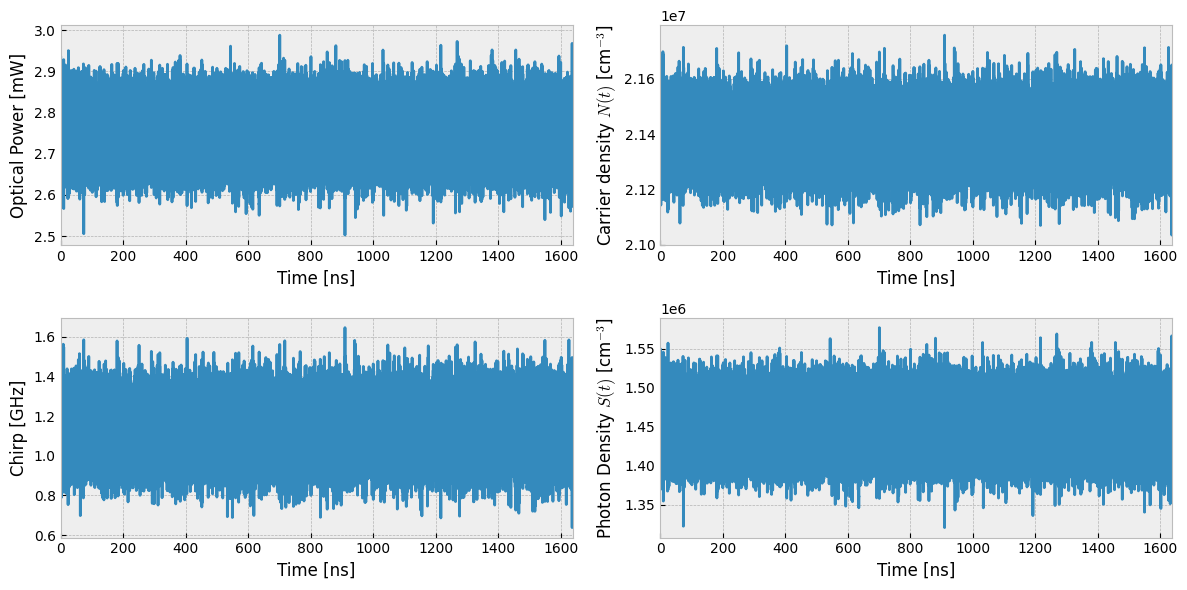

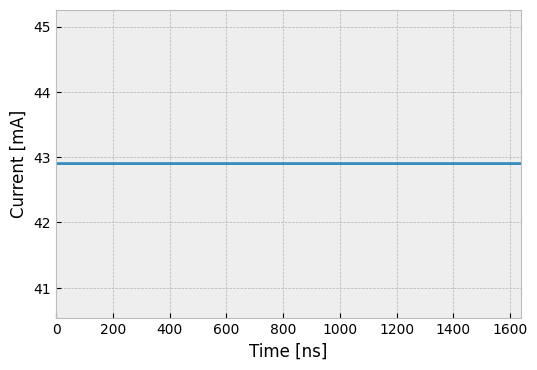

In [92]:
laser_dfb_parameters.noise_terms = True
laser2 = laser_dfb(laser_dfb_parameters)
sol = laser2.solve(t, sigTx)

laser2.plot()
print('I_threshold: %.3f mA'%(1e3*laser2.ith))
print('I_on: %.3f mA'%(1e3*np.real(laser2.current.max())))
print('I_off: %.3f mA'%(1e3*np.real(laser2.current.min())))

plt.figure(figsize=(6,4))
plt.plot(1e9*laser2.t, 1e3*laser2.current)
plt.xlabel('Time [ns]')
plt.ylabel('Current [mA]')
plt.xlim([1e9*t.min(), 1e9*t.max()])
plt.grid(True)

Text(0.5, 1.0, 'DFB laser spectrum')

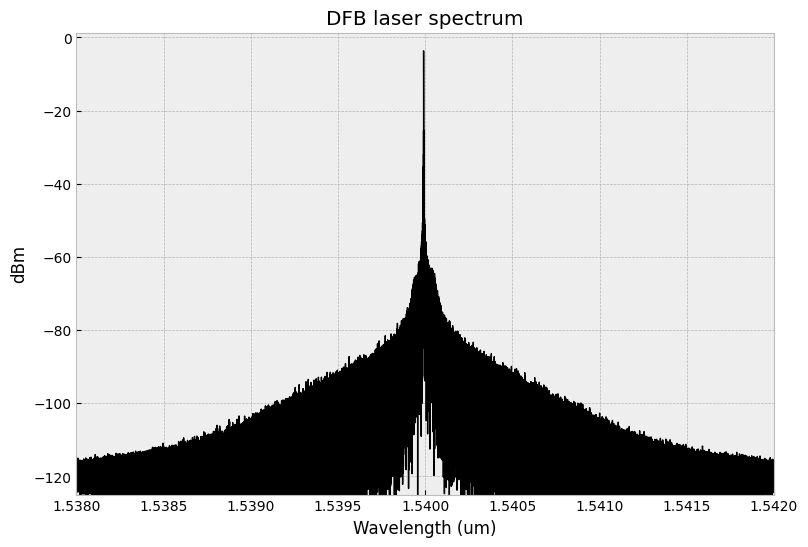

In [93]:
freq, spectrum = get_spectrum(laser2.e_out, Fs=Fs, Fc=c/laser2.lmbd)
plt.plot(freq*1e6, spectrum, color='black',linewidth = 1)
plt.xlim(1.538,1.542)
plt.ylim(-125,np.max(spectrum)+5)
plt.ylabel('dBm')
plt.xlabel('Wavelength (um)')
plt.title('DFB laser spectrum')

## Spectral representation: Comparison

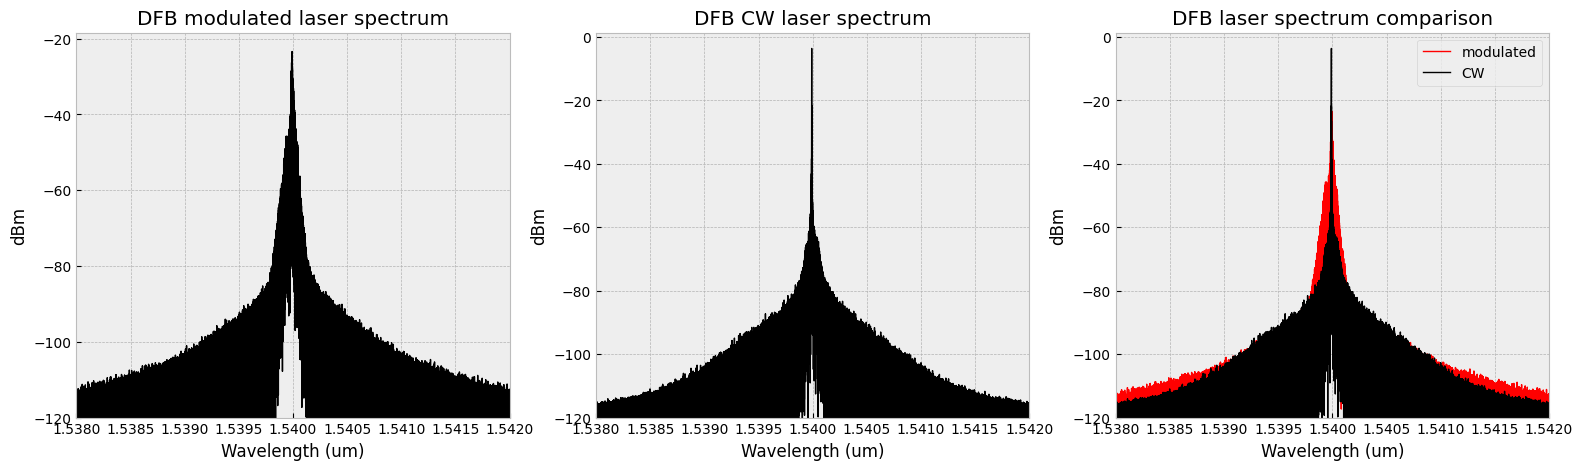

In [95]:
fig, ax = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(19)

freq1, spectrum1 = get_spectrum(laser1.e_out, Fs=Fs, Fc=c/laser1.lmbd)
ax[0].plot(freq1*1e6, spectrum1, color='black',linewidth = 1)
ax[0].set_xlim(1.538,1.542)
ax[0].set_ylim(-120,np.max(spectrum1)+5)
ax[0].set_ylabel('dBm')
ax[0].set_xlabel('Wavelength (um)')
ax[0].set_title('DFB modulated laser spectrum')

freq2, spectrum2 = get_spectrum(laser2.e_out, Fs=Fs, Fc=c/laser2.lmbd)
ax[1].plot(freq2*1e6, spectrum2, color='black',linewidth = 1)
ax[1].set_xlim(1.538,1.542)
ax[1].set_ylim(-120,np.max(spectrum2)+5)
ax[1].set_ylabel('dBm')
ax[1].set_xlabel('Wavelength (um)')
ax[1].set_title('DFB CW laser spectrum')

ax[2].plot(freq1*1e6, spectrum1, color='red',linewidth = 1, label='modulated')
ax[2].plot(freq2*1e6, spectrum2, color='black',linewidth = 1, label='CW')
ax[2].set_xlim(1.538,1.542)
ax[2].set_ylim(-120,np.max(np.concatenate((spectrum1,spectrum2)))+5)
ax[2].set_ylabel('dBm')
ax[2].set_xlabel('Wavelength (um)')
ax[2].set_title('DFB laser spectrum comparison')
ax[2].legend()

# RIN and Linewidth

In [ ]:
# simulation parameters
SpS = 16
Rs = 3.125e9   # Symbol rate (for OOK case Rs = Rb)
Tsymb = 1/Rs # Symbol period in seconds
Fs = 1/(Tsymb/SpS) # Signal sampling frequency (samples/second)
Ts = 1/Fs # Sampling period

# generate bit sequence of "0"
bitsTx = np.zeros(2**12)

# upsampling
symbolsUp = upsample(bitsTx, SpS)

# typical NRZ pulse
pulse = pulseShape('rect', SpS)
pulse = pulse/max(abs(pulse))

# pulse formatting
sigTx = firFilter(pulse, symbolsUp)
sigTx = shift(sigTx, int(SpS/2), cval=sigTx[0])
t = np.arange(0,SpS*len(bitsTx))*Ts

In [20]:
sol = laser.solve(t, sigTx)

c:\Users\PC\Documents\GitHub\Laser-Study\Tests\..\Functions\laser_dfb.py:120: RuntimeWarning: invalid value encountered in sqrt
  fz = np.random.randn()*np.sqrt(2*dzz/self.t_step)


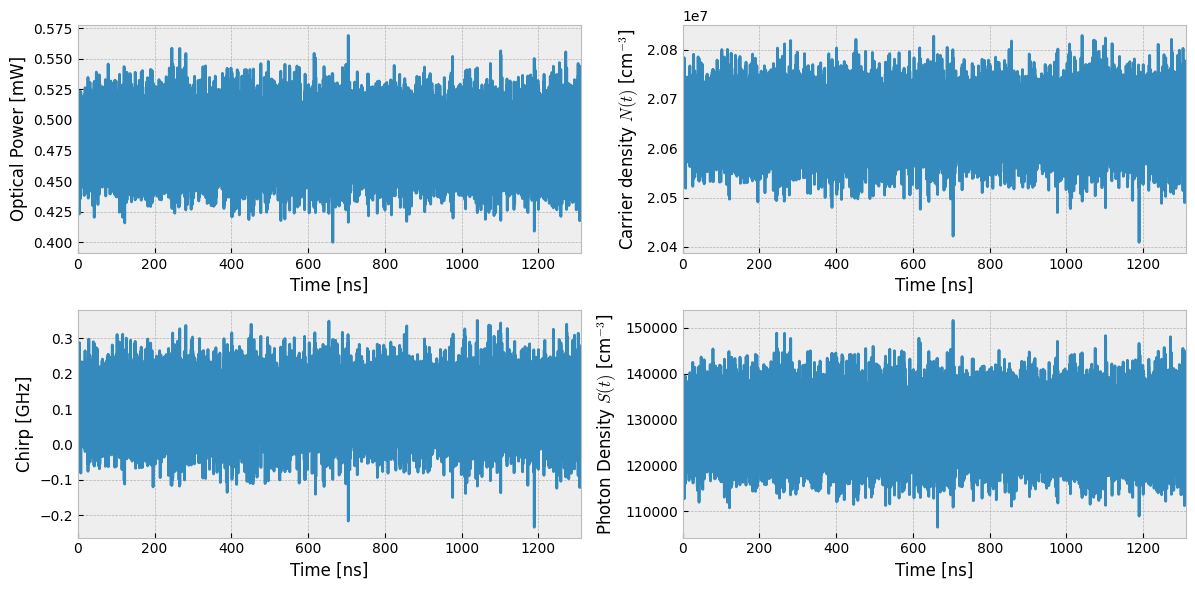

In [21]:
ax = laser.plot()

(0.75, 1.15)

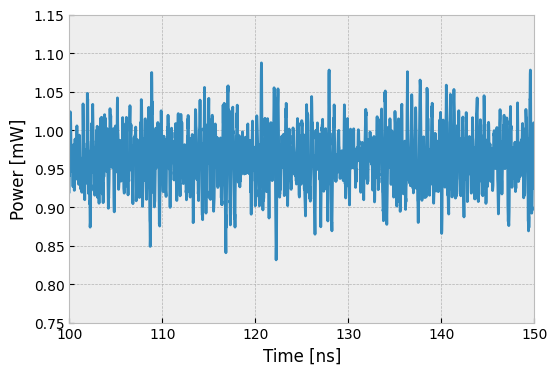

In [22]:
p_t = laser.eta_0*h*laser.freq_0/laser.tau_p * laser.S # Equation [13] of reference.
plt.figure(figsize=(6,4))
plt.plot(1e9*laser.t, 1e3*p_t)
plt.xlabel('Time [ns]')
plt.ylabel('Power [mW]')
plt.xlim([100,150])
plt.ylim([.75,1.15])

In [23]:
indx = np.squeeze(np.argwhere(t > 100e-9))
p_t = p_t[indx[0]:]
p_mean  = np.mean(p_t)
p_delta = p_t - p_mean

In [24]:
# Get RIN
F, P = signal.periodogram(p_delta, Fs, scaling='density')
rin = P/p_mean**2
# Filter
b = signal.firwin(numtaps = 50, cutoff = 0.01, window='hamming')
rin_t = firFilter(b, rin)

(0.01, 10)

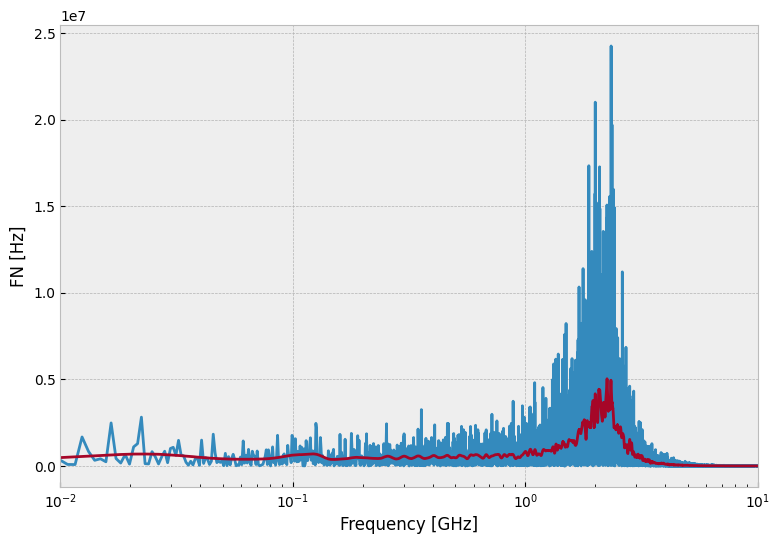

In [27]:
# Get FN
Fc, C = signal.periodogram(laser.chirp[indx[0:]], Fs, scaling='density')
# Filter
b = signal.firwin(numtaps = 50, cutoff = 0.01, window='hamming')
phase_noise = firFilter(b, C)
# Plot
plt.semilogx(1e-9*Fc,C)
plt.semilogx(1e-9*Fc,phase_noise)
plt.xlabel('Frequency [GHz]')
plt.ylabel('FN [Hz]')
plt.xlim([0.01,10])

In [28]:
# Analitical RIN
from scipy.constants import e
I = laser_dfb_parameters.i_bias
g = 1.13e4
laser.epsilon = laser.epsilon/laser.v
laser.n_t = laser.n_t*laser.v

In [29]:
a = e*(laser.epsilon + g*laser.tau_n)
b = e+g*laser.tau_p*((1-laser.beta)*laser.n_t*e - laser.tau_n*I)-laser.beta*laser.epsilon*laser.tau_p*I
c = -laser.beta*laser.tau_p*I

In [30]:
S = (-b + np.sqrt(b**2-4*a*c))/(2*a)
N = (laser.tau_n/e)*((I*(1+laser.epsilon*S)+g*laser.n_t*e*S)/(1+laser.epsilon*S+g*S*laser.tau_n))

In [31]:
Y = 1/laser.tau_n + 1/laser.tau_p + g/(1+laser.epsilon*S) * (S-(N-laser.n_t)/(1+laser.epsilon*S))
Z = 1/(laser.tau_n*laser.tau_p)+ g/(1+laser.epsilon*S) * (S/laser.tau_p - ((1-laser.beta)/laser.tau_n) * (N-laser.n_t)/(1+laser.epsilon*S))
A = ((1/laser.tau_n**2)*((1-laser.beta)**2+laser.beta/S)+g/(1+laser.epsilon*S)*(2/laser.tau_n + (S/laser.beta) * (g/(1+laser.epsilon*S))))**-1
R = 2*(laser.tau_p**2)*((1+laser.epsilon*S)**2)*N
R = R * (laser.beta*(S*(1-laser.beta)**2+laser.beta)*(1+laser.epsilon*S)**2+g*S*laser.tau_n*(g*S*laser.tau_n+2*laser.beta*laser.epsilon*S+2*laser.beta))
R = R/(S**2*laser.tau_n*(laser.tau_p*g*(1-laser.beta)*(N-laser.n_t)-(1+laser.epsilon*S)*(g*S*laser.tau_n+(1+laser.epsilon*S)))**2)

In [32]:
f = np.linspace(50e6,8e9,1000)
w = 2*np.pi*f
RIN = (R*Z**2*(1+A*w**2))/(Z**2+(Y**2-2*Z)*w**2+w**4)

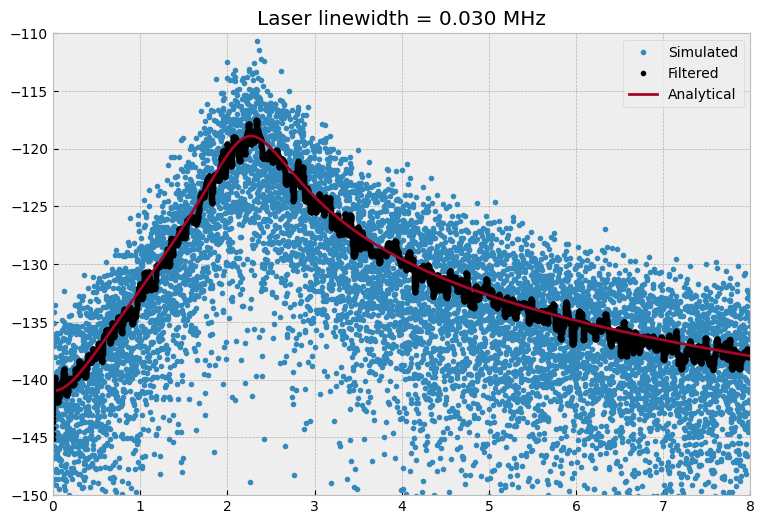

In [33]:
# Compare 
plt.plot(1e-9*F, 10*np.log10(rin),'.',label='Simulated')
plt.plot(1e-9*F, 10*np.log10(rin_t),'k.',label='Filtered')
plt.plot(1e-9*f, 10*np.log10(RIN),label='Analytical')
plt.title('Laser linewidth = %.3f MHz'%(1e-6*phase_noise[0]/(2*np.pi)))
plt.xlim([0,8])
plt.ylim([-150,-110])
plt.legend()